In [91]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler, MinMaxScaler
%matplotlib notebook
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import time

In [92]:
# import torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import TensorDataset
from torch.nn.utils.rnn import pad_sequence
from torch.autograd import Variable

In [93]:
from pathlib import Path
import json
from typing import Dict, List, Optional, Any, Union

In [94]:
import logging
from collections import OrderedDict
from functools import partial

In [5]:
#!!!------------------------
# pip install holoviews[all]
#!!!------------------------
# Required for umap


#import holoviews

### Path to download and retrieve data

In [6]:
default_dataset_path = Path("D:\\OneDrive - Kaunas University of Technology\\4 Magistrinis\\Project\\data_clean")

In [7]:
# default_dataset_path = Path("D:\\OneDrive - Kaunas University of Technology\\4 Magistrinis\\Project\\data_short")

### Utility functions

In [8]:
def save_to_file(path: Path, data: List[Dict]):
    print(f"saving time-series into {path}")
    path_dir = os.path.dirname(path)
    os.makedirs(path_dir, exist_ok=True)
    with open(path, "wb") as fp:
        for d in data:
            fp.write(json.dumps(d).encode("utf-8"))
            fp.write("\n".encode("utf-8"))

In [9]:
def metadata(
    cardinality: Union[int, List[int]], freq: str
):
    return {
        "freq": freq,
        "feat_static_cat": [
            {"name": "feat_static_cat", "cardinality": str(cardinality)}
        ],
    }

In [10]:
def to_dict(
    target_values: np.ndarray,
    start: str,
    cat: Optional[List[int]] = None,
    item_id: Optional[Any] = None,
):
    def serialize(x):
        if np.isnan(x):
            return "NaN"
        else:
            # return x
            return float("{0:.6f}".format(float(x)))

    res = {
        "start": str(start),
        "target": [serialize(x) for x in target_values],
    }

    if cat is not None:
        res["feat_static_cat"] = cat

    if item_id is not None:
        res["item_id"] = item_id

    return res

### Function to download M4 dataset

In [11]:
def generate_m4_dataset(
    dataset_path: Path, m4_freq: str, pandas_freq: str):
    m4_dataset_url = (
        "https://github.com/M4Competition/M4-methods/raw/master/Dataset"
    )
    train_df = pd.read_csv(
        f"{m4_dataset_url}/Train/{m4_freq}-train.csv", index_col=0
    )
    test_df = pd.read_csv(
        f"{m4_dataset_url}/Test/{m4_freq}-test.csv", index_col=0
    )
    
    os.makedirs(dataset_path, exist_ok=True)
    
    with open(dataset_path / "metadata.json", "w") as f:
        f.write(
            json.dumps(
                metadata(
                    cardinality=len(train_df),
                    freq=pandas_freq
                )
            )
        )
        
    train_file = dataset_path / "train" / "data.json"
    test_file = dataset_path / "test" / "data.json"
    
    # Fills NaNs with 0 to equalise lengths
    fillZero = False
    if fillZero: train_df = train_df.fillna(0)
    
    cutToShortest = False
    if cutToShortest:
        minLength = (~np.isnan(train_df)).sum(axis = 1).min()
        train_df = train_df.iloc[:, : minLength]
    
    train_target_values = [ts[~np.isnan(ts)] for ts in train_df.values]
#     train_target_values = [ts.replace(np.nan, 0) for ts in train_df.values]
    
    #Skip test data
    addTest = False
    if(addTest):
        # Adds test series to the back of train series
        test_target_values = [
            np.hstack([train_ts, test_ts])
            for train_ts, test_ts in zip(train_target_values, test_df.values)
        ]

    # Earliest point available in pandas
    mock_start_dataset = "1750-01-01 00:00:00"
    
    save_to_file(
        train_file,
        [
            to_dict(
                target_values=target,
                start=mock_start_dataset,
                cat=[cat],
                item_id=cat,
            )
            for cat, target in enumerate(train_target_values)
        ],
    )
    
    if(addTest):
        save_to_file(
            test_file,
            [
                to_dict(
                    target_values=target,
                    start=mock_start_dataset,
                    cat=[cat],
                    item_id=cat,
                )
                for cat, target in enumerate(test_target_values)
            ],
        )
            
    return train_target_values

### Function to download data if it's not downloaded yet

In [12]:
# Calls download function if the data is not downloaded yet

def materialize_dataset(
    dataset_name: str,
    path: Path = default_dataset_path,
    regenerate: bool = False,
) -> Path:
    
    path.mkdir(parents=True, exist_ok=True)
    dataset_path = path / dataset_name

    dataset_recipe = dataset_recipes[dataset_name]

    if not dataset_path.exists() or regenerate:
        print(f"Downloading and processing {dataset_name}")
        dataset_recipe(dataset_path=dataset_path)
    else:
        print(
            f"Using dataset already processed in path {dataset_path}."
        )

    return dataset_path

### Time series to use and download

In [13]:
dataset_recipes = OrderedDict(
    {
        "m4_hourly": partial(
            generate_m4_dataset,
            m4_freq="Hourly",
            pandas_freq="H",
        ),
        "m4_daily": partial(
            generate_m4_dataset,
            m4_freq="Daily",
            pandas_freq="D",
        ),
        "m4_weekly": partial(
            generate_m4_dataset,         
            m4_freq="Weekly",
            pandas_freq="W",
        ),
        "m4_monthly": partial(
            generate_m4_dataset,
            m4_freq="Monthly",
            pandas_freq="M",
        ),
        "m4_quarterly": partial(
            generate_m4_dataset,
            m4_freq="Quarterly",
            pandas_freq="3M",
        ),

    }
)

In [14]:
#List of time series
dataset_names = list(dataset_recipes.keys())

In [15]:
#Force redownload and reprocess of data
regenerate = False

for dataset in dataset_names:
        dataset_path = default_dataset_path / dataset
        dataset_recipe = dataset_recipes[dataset]
        print(f"\ngenerate {dataset}")
        ds = materialize_dataset(dataset_name=dataset, regenerate = regenerate)
#         print(ds.metadata)
#         print(sum(1 for _ in list(iter(ds.train))))


generate m4_hourly
Using dataset already processed in path D:\OneDrive - Kaunas University of Technology\4 Magistrinis\Project\data_clean\m4_hourly.

generate m4_daily
Using dataset already processed in path D:\OneDrive - Kaunas University of Technology\4 Magistrinis\Project\data_clean\m4_daily.

generate m4_weekly
Using dataset already processed in path D:\OneDrive - Kaunas University of Technology\4 Magistrinis\Project\data_clean\m4_weekly.

generate m4_monthly
Using dataset already processed in path D:\OneDrive - Kaunas University of Technology\4 Magistrinis\Project\data_clean\m4_monthly.

generate m4_quarterly
Using dataset already processed in path D:\OneDrive - Kaunas University of Technology\4 Magistrinis\Project\data_clean\m4_quarterly.


# Data preparation

In [16]:
dataset_path = default_dataset_path / "m4_quarterly"
trainDataset = dataset_path / "train" / "data.json"

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 32
# percentage of training set to use as validation
valid_size = 0.2

# check if GPU is available
train_on_gpu = torch.cuda.is_available()
#train_on_gpu = False
if(train_on_gpu):
    print('Training on GPU!')
else: 
    print('No GPU available, training on CPU.')

Training on GPU!


In [17]:
# Read the data from file
myData = pd.read_json(trainDataset, lines=True)

In [18]:
# If data is of uneven length pad with 0 and transform to tensor
paddedData = pad_sequence([torch.tensor(x) for x in myData['target'].values], batch_first=True)

# Lengths of vectors
lens = torch.count_nonzero(paddedData, dim=1)

# Mask of unpadded values
paddedMask = pad_sequence([torch.tensor(x*[True]) for x in lens], batch_first=True)

In [19]:
# scaler = StandardScaler()
scaler = MinMaxScaler()
# scaledData = scaler.fit_transform(list(myData.target))

scaledData = scaler.fit_transform(paddedData)

#Tensor for series
train_data = torch.from_numpy(scaledData).float()

# Join tensors
fullDataset = TensorDataset(train_data, paddedMask)

In [20]:
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(fullDataset, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(fullDataset, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)

trainMask_loader = torch.utils.data.DataLoader(paddedMask, batch_size=batch_size, 
    sampler=train_sampler, num_workers=num_workers)
validMask_loader = torch.utils.data.DataLoader(paddedMask, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)

# Variational autoencoder

In [21]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        
        # Network architecture
        fc1Size = 2048
        fc2Size = 1024
        fc3Size = 1024
        self.hidden_size = 512
        
        #Encoder
        self.fc1 = nn.Linear(866, fc1Size)
        self.fc2 = nn.Linear(fc1Size, fc2Size)
        self.fc3 = nn.Linear(fc2Size, fc3Size)
        
        #Latent space
        self.hidden2mu = nn.Linear(fc3Size, self.hidden_size)
        self.hidden2log_var = nn.Linear(fc3Size, self.hidden_size)
        
        #Decoder
        self.fc4 = nn.Linear(self.hidden_size, fc3Size)
        self.fc5 = nn.Linear(fc3Size, fc2Size)
        self.fc6 = nn.Linear(fc2Size, fc1Size)
        
        self.fc7 = nn.Linear(fc1Size, 866)
        
        #functions
        self.ReLU = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def encoder(self,x):
        x = self.ReLU(self.fc1(x))
        x = self.ReLU(self.fc2(x))
        x = self.ReLU(self.fc3(x))
        
        mu, log_var = self.hidden2mu(x), self.hidden2log_var(x)
        return mu, log_var
    
    def reparametrize(self, mu, log_var):
        # Reparametrization Trick to allow gradients to backpropagate from the
        # stochastic part of the model
        sigma = torch.exp(0.5*log_var)
        z = torch.randn_like(sigma)
        return mu + sigma*z
    
    def decoder(self,x):
        x = self.ReLU(self.fc4(x))
        x = self.ReLU(self.fc5(x))
        x = self.ReLU(self.fc6(x))
        
        x = self.sigmoid(self.fc7(x))
        x = torch.clamp(x, min=0.0, max=1.0)
        return x

    def forward(self,x):
        batch_size = x.size(0)
        x = x.view(batch_size, 866)
        
        mu, log_var = self.encoder(x) 
        x = self.reparametrize(mu, log_var)
        x = self.decoder(x)  
        return mu, log_var, x

# Convolutional autoencoder

In [22]:
class CONV(nn.Module):
    
    def __init__(self, seriesLength):
        super().__init__()
        
        self.ReLU = nn.LeakyReLU(0.01, True)
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        
        self.seriesLength = seriesLength
        
        self.conv1Size = 32
        self.conv2Size = 16
        self.conv3Size = 128
        
        self.z_dim = 96
        
        
        self.conv1 = nn.Conv1d(1,self.conv1Size, kernel_size=7, stride=2, padding = 3)
        self.pool1 = nn.MaxPool1d(kernel_size = 7, stride=2, padding=3, return_indices=True)
        self.bn1   = nn.BatchNorm1d(self.conv1Size, eps=0.001, momentum=0.99)
        
        self.conv2 = nn.Conv1d(self.conv1Size,self.conv2Size, kernel_size=7, stride=2, padding = 3)
        self.pool2 = nn.MaxPool1d(kernel_size = 7, stride=2, padding=3, return_indices=True)
        self.bn2   = nn.BatchNorm1d(self.conv2Size, eps=0.001, momentum=0.99)
        
        self.conv3 = nn.Conv1d(self.conv2Size,self.conv3Size, kernel_size=7, stride=2, padding = 3)
        self.pool3 = nn.MaxPool1d(kernel_size = 7, stride=2, padding=3, return_indices=True)
        self.bn3   = nn.BatchNorm1d(self.conv3Size, eps=0.001, momentum=0.99)
        
        # Latent space
        self.flatten = nn.Flatten(start_dim = 1)   
        self.fc4 = nn.Linear(3472, self.z_dim)
        
        # Decoder
        self.fc5 = nn.Linear(self.z_dim, 3472)
        
        self.convT1 = nn.ConvTranspose1d(self.conv2Size, self.conv2Size, kernel_size=7, stride=2, padding = 3)
        self.unpool1 = nn.MaxUnpool1d(kernel_size = 7, stride=2, padding=3)
        self.bnT1   = nn.BatchNorm1d(self.conv1Size, eps=0.001, momentum=0.99)
        
        self.convT2 = nn.ConvTranspose1d(self.conv2Size, self.conv1Size, kernel_size=7, stride=2, padding = 3)
        self.unpool2 = nn.MaxUnpool1d(kernel_size = 7, stride=2, padding=3)
        self.bnT2   = nn.BatchNorm1d(1, eps=0.001, momentum=0.99)
        
        self.convT3 = nn.ConvTranspose1d(self.conv1Size, 1, kernel_size=7, stride=1, padding = 2)
        
        self.fcFinal = nn.Linear(867, self.seriesLength)
#         u1 = nn.MaxUnpool1d(2)
#         d2 = nn.ConvTranspose1d(16, in_size, 3)
        
        
    def encoder(self, x):        
        
        self.batch_size = x.size(0)
        
        x = x.reshape(self.batch_size,1, self.seriesLength)
        
        x = self.ReLU(self.conv1(x))
#         x, self.indices1 = self.pool1(x)
#         x = self.ReLU(self.bn1(x))
        
#         x, self.indices2 = self.pool2(self.conv2(x))

        x = self.ReLU(self.conv2(x))
#         x = self.ReLU(self.bn2(x))
        x = self.flatten(x)
        x = self.fc4(x)
#         x = self.ReLU(self.bn3(self.pool3(self.conv3(x))))
#         x = self.fc4(self.flatten(x)) #Latent space
        return x
    
    def decoder(self, x):
        
#         x = self.fc5(x) # Return the tensor to shape
#         x = x.reshape(32,self.conv2Size,4)
        x = self.fc5(x)
        x = x.view(self.batch_size, self.conv2Size, -1)
        
        x = self.ReLU(self.convT1(x))
        x = self.ReLU(self.convT2(x))
        
        x = self.convT3(x)
#         x = self.ReLU(self.bnT1(self.convT1(x)))
#         x = self.ReLU(self.bnT2(self.convT2(x)))
        x = x.reshape(self.batch_size,867)
        x = self.fcFinal(x)    

#         x = self.unpool1(x, self.indices2)
#         x = self.convT1(x)
#         x = self.bnT1(x)
#         x = self.ReLU(x)
        
#         x = self.ReLU(self.bnT1(self.convT1(self.unpool1(x, self.indices2))))
#         x = self.ReLU(self.bnT1(self.convT1(x)
#         x = self.tanh(self.bnT2(self.convT2(self.unpool2(x, self.indices1))))
#         x = self.ReLU(self.bnT2(self.unpool2(self.convT2(x))))
        

        return x

    def forward(self, input, **kwargs):
        x = self.encoder(input)
        x = self.decoder(x)
        return [0,0,x]



# Loss functions

In [23]:
def VAE_loss(output, data, mu, log_var, alpha):
    # Reconstruction error + KL-divergence error    
    # Get batch size
    batch_size = data.size(0)
    # KL-divergence error
    kl_loss = (-0.5*(1+log_var - mu**2 -
        torch.exp(log_var)).sum(dim=1)).mean(dim=0)
    # Reconstruction loss
    recon_loss = criterion(output, data)
    # Total model loss
    loss = recon_loss*alpha + kl_loss #- falseLoss
    
    return loss

In [24]:
def mse_loss(input, target, mask, reduction = "mean"):
    # MSEloss modified with a mask input (values to omit from calculation)
    out = (input[mask]-target[mask])**2
    if reduction == "mean":
        return out.mean()
    elif reduction == "None":
        return out

# Creating objects for model

In [25]:
# Length of the input
seriesLen = 866

# Model init
# model = VAE()             # Variational autoencoder model
model = CONV(seriesLen)     # Convolutional autoencoder model

# Loss function
criterion = nn.MSELoss()
# criterion = nn.BCELoss(reduction='sum')

# Optimizer
# Need to reinitialise everytime
optimizer = torch.optim.Adam(model.parameters(), lr=0.005) #, amsgrad = True
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

# Transfer model to GPU if available
if(train_on_gpu):
    print('Training on GPU!')
    model.cuda()
else: 
    print('No GPU available, training on CPU.')

Training on GPU!


In [69]:
model

CONV(
  (ReLU): LeakyReLU(negative_slope=0.01, inplace=True)
  (sigmoid): Sigmoid()
  (tanh): Tanh()
  (conv1): Conv1d(1, 32, kernel_size=(7,), stride=(2,), padding=(3,))
  (pool1): MaxPool1d(kernel_size=7, stride=2, padding=3, dilation=1, ceil_mode=False)
  (bn1): BatchNorm1d(32, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
  (conv2): Conv1d(32, 16, kernel_size=(7,), stride=(2,), padding=(3,))
  (pool2): MaxPool1d(kernel_size=7, stride=2, padding=3, dilation=1, ceil_mode=False)
  (bn2): BatchNorm1d(16, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
  (conv3): Conv1d(16, 128, kernel_size=(7,), stride=(2,), padding=(3,))
  (pool3): MaxPool1d(kernel_size=7, stride=2, padding=3, dilation=1, ceil_mode=False)
  (bn3): BatchNorm1d(128, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc4): Linear(in_features=3472, out_features=96, bias=True)
  (fc5): Linear(in_features=96, out_features=3472

# Training

In [104]:
# number of epochs to train the model
n_epochs = 50

# initialize tracker for minimum validation loss
valid_loss_min = np.Inf # set initial "min" to infinity

alpha = 1 #Reconstruction loss multiplier (Higher values prioritise reconstruction loss over KL-divergence error)

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    start = time.time()
    ###################
    # train the model #
    ###################
    model.train() # prep model for training
    for data, mask in (train_loader):
        if(train_on_gpu):
            data = data.cuda()
            
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        mu, log_var, output = model(data)
        #Calculate training loss        
#         loss = criterion(data, output)
        loss = mse_loss(data,output,mask)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()
        
    ######################    
    # validate the model #
    ######################
    model.eval() # prep model for evaluation
    for data, mask in (valid_loader):
        if(train_on_gpu):
            data = data.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        mu, log_var, output = model(data)
        #Calculate validation loss
#         loss = criterion(data, output)
        loss = mse_loss(data,output,mask)
        # update running validation loss 
        valid_loss += loss.item()
        
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader)
    valid_loss = valid_loss/len(valid_loader)
    
    #Decay the learning rate
    scheduler.step()
    
    end = time.time()
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tEpoch training time: {:.2f}s'.format(
        epoch+1, 
        train_loss,
        valid_loss,
        end-start
        ))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.000887 	Validation Loss: 0.000938 	Epoch training time: 4.96s
Validation loss decreased (inf --> 0.000938).  Saving model ...
Epoch: 2 	Training Loss: 0.000877 	Validation Loss: 0.000924 	Epoch training time: 4.90s
Validation loss decreased (0.000938 --> 0.000924).  Saving model ...
Epoch: 3 	Training Loss: 0.000872 	Validation Loss: 0.000924 	Epoch training time: 4.90s
Epoch: 4 	Training Loss: 0.000864 	Validation Loss: 0.000927 	Epoch training time: 4.80s
Epoch: 5 	Training Loss: 0.000862 	Validation Loss: 0.000921 	Epoch training time: 4.80s
Validation loss decreased (0.000924 --> 0.000921).  Saving model ...
Epoch: 6 	Training Loss: 0.000856 	Validation Loss: 0.000910 	Epoch training time: 4.78s
Validation loss decreased (0.000921 --> 0.000910).  Saving model ...
Epoch: 7 	Training Loss: 0.000854 	Validation Loss: 0.000914 	Epoch training time: 4.91s
Epoch: 8 	Training Loss: 0.000849 	Validation Loss: 0.000918 	Epoch training time: 5.14s
Epoch: 9 	Trainin

In [105]:
model.load_state_dict(torch.load('model.pt'))

t1, t2, output = model(data)

# Visualise last batch

Rerun cell to iterate over batch

In [106]:
n = 1

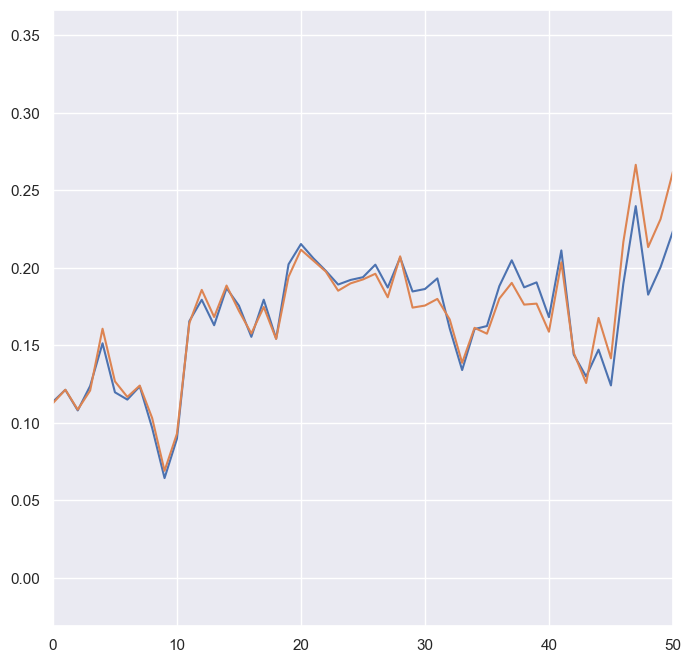

In [114]:
visOut = output.cpu()
visData = data.cpu()

# visOutBest = outputBest.cpu()
minim = visData[n,:50].min().detach()
maxim = visData[n,:50].max().detach()


# visOut[1].detach().numpy()
# visData[1].detach().numpy()
plt.plot(visOut[n].detach().numpy())
# plt.plot(visOutBest[4].detach().numpy())
plt.plot(visData[n].detach().numpy())
plt.xlim([0, 50])
plt.ylim([minim-0.1,maxim+0.1])
n += 1
# plt.plot(visOutBest[1].detach().numpy())

# Sample latent space

In [115]:
latentFull = torch.cuda.FloatTensor()

for series, mask in fullDataset:
    # Transfer to GPU
    if(train_on_gpu):
            series = series.cuda()
    # Format batch size of 1
    series = series.view(1,-1)
    # Sample latent space from series
    latentSample = model.encoder(series)
    latentFull = torch.cat((latentFull, latentSample), 0)
    
latentFull = latentFull.cpu().detach()

In [116]:
latentFull.size()

torch.Size([24000, 96])

# t-SNE

In [52]:
from sklearn.manifold import TSNE
from matplotlib import cm

In [53]:
tsne = TSNE(2, verbose=1)
tsne_proj_2D = tsne.fit_transform(latentFull)

c:\users\aurelijus\appdata\local\programs\python\python38\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\users\aurelijus\appdata\local\programs\python\python38\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 24000 samples in 0.002s...
[t-SNE] Computed neighbors for 24000 samples in 13.036s...
[t-SNE] Computed conditional probabilities for sample 1000 / 24000
[t-SNE] Computed conditional probabilities for sample 2000 / 24000
[t-SNE] Computed conditional probabilities for sample 3000 / 24000
[t-SNE] Computed conditional probabilities for sample 4000 / 24000
[t-SNE] Computed conditional probabilities for sample 5000 / 24000
[t-SNE] Computed conditional probabilities for sample 6000 / 24000
[t-SNE] Computed conditional probabilities for sample 7000 / 24000
[t-SNE] Computed conditional probabilities for sample 8000 / 24000
[t-SNE] Computed conditional probabilities for sample 9000 / 24000
[t-SNE] Computed conditional probabilities for sample 10000 / 24000
[t-SNE] Computed conditional probabilities for sample 11000 / 24000
[t-SNE] Computed conditional probabilities for sample 12000 / 24000
[t-SNE] Computed conditional probabilities for sa

In [54]:
# Bad plot

# cmap = cm.get_cmap('tab20')
# fig, ax = plt.subplots(figsize=(8,8))
# ax.scatter(tsne_proj_2D[:,0],tsne_proj_2D[:,1],alpha=0.5)

In [55]:
# library & dataset
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [56]:
df = pd.DataFrame({'x':tsne_proj_2D[:,0], 'y':tsne_proj_2D[:,1]})

<AxesSubplot:xlabel='x', ylabel='y'>

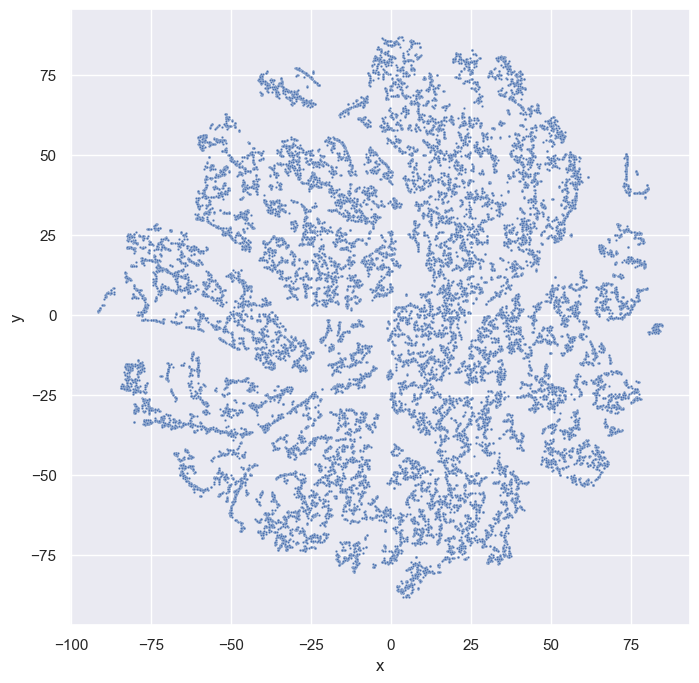

In [57]:
sns.set(rc = {'figure.figsize':(8,8)})
sns.scatterplot(data=df, x = 'x', y = 'y', s = 3)

In [58]:
tsne = TSNE(3, verbose=1)
tsne_proj_3D = tsne.fit_transform(latentFull)

c:\users\aurelijus\appdata\local\programs\python\python38\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\users\aurelijus\appdata\local\programs\python\python38\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 24000 samples in 0.002s...
[t-SNE] Computed neighbors for 24000 samples in 12.916s...
[t-SNE] Computed conditional probabilities for sample 1000 / 24000
[t-SNE] Computed conditional probabilities for sample 2000 / 24000
[t-SNE] Computed conditional probabilities for sample 3000 / 24000
[t-SNE] Computed conditional probabilities for sample 4000 / 24000
[t-SNE] Computed conditional probabilities for sample 5000 / 24000
[t-SNE] Computed conditional probabilities for sample 6000 / 24000
[t-SNE] Computed conditional probabilities for sample 7000 / 24000
[t-SNE] Computed conditional probabilities for sample 8000 / 24000
[t-SNE] Computed conditional probabilities for sample 9000 / 24000
[t-SNE] Computed conditional probabilities for sample 10000 / 24000
[t-SNE] Computed conditional probabilities for sample 11000 / 24000
[t-SNE] Computed conditional probabilities for sample 12000 / 24000
[t-SNE] Computed conditional probabilities for sa

<IPython.core.display.Javascript object>


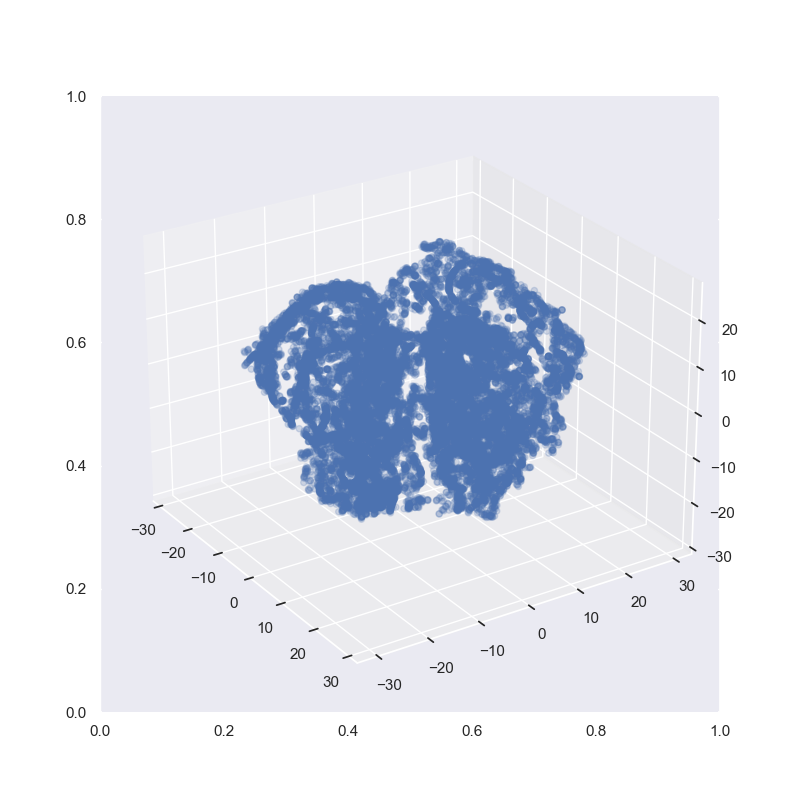

In [59]:
%matplotlib notebook

cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
ax.scatter(tsne_proj_3D[:, 0],tsne_proj_3D[:, 1],tsne_proj_3D[:, 2],alpha=0.2)

plt.show()

# PCA

In [60]:
from sklearn.decomposition import PCA

In [119]:
pca = PCA(n_components=2)
pca.fit(latentFull)
pca_proj_2D = pca.transform(latentFull)
pca.explained_variance_ratio_

array([0.55960299, 0.25534653])

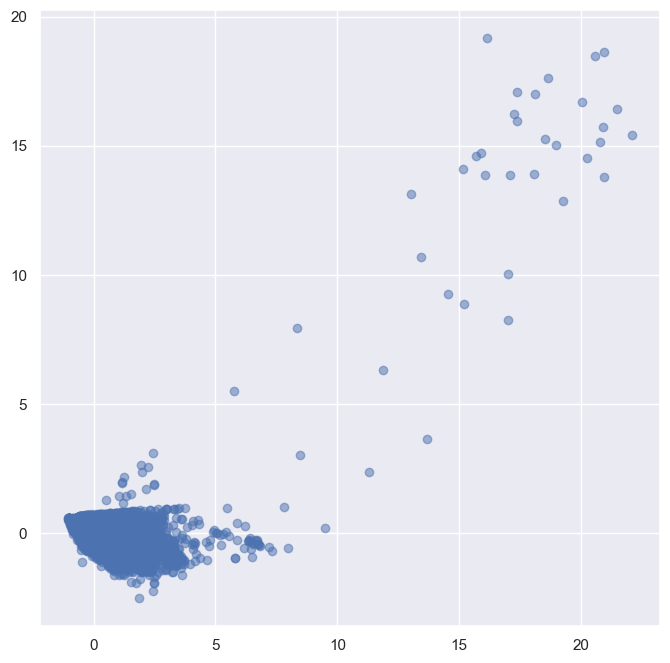

In [120]:
cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(pca_proj_2D[:,0],pca_proj_2D[:,1],alpha=0.5)

In [63]:
pca = PCA(n_components=3)
pca.fit(latentFull)
pca_proj_3D = pca.transform(latentFull)
pca.explained_variance_ratio_

array([0.55397443, 0.25728977, 0.09717874])

<IPython.core.display.Javascript object>


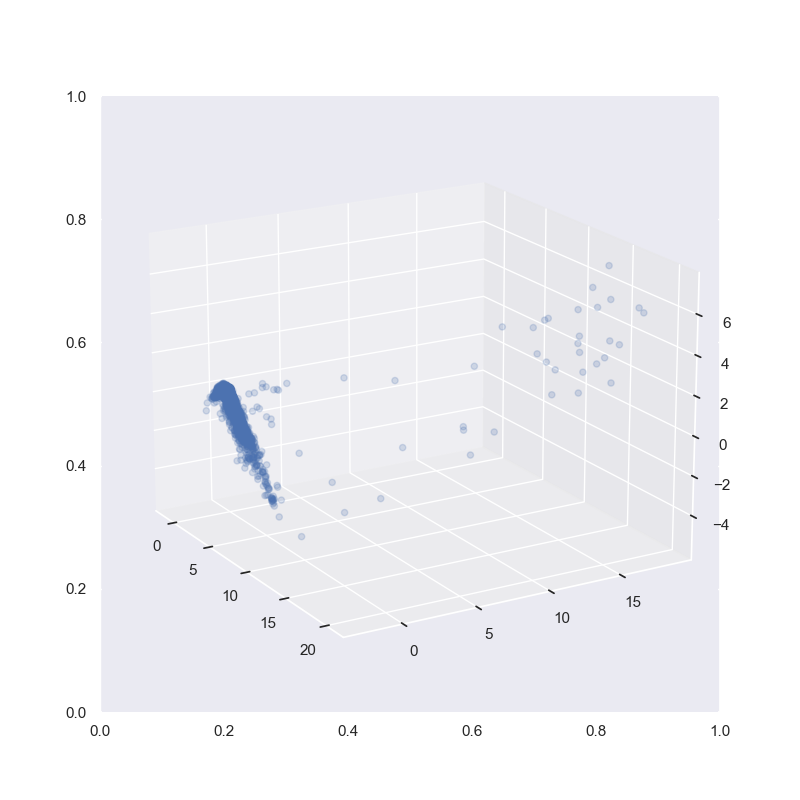

In [64]:
cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
ax.scatter(pca_proj_3D[:, 0],pca_proj_3D[:, 1],pca_proj_3D[:, 2],alpha=0.2)
plt.ion()
plt.show()

# UMAP

In [117]:
import umap.umap_ as umap
mapper = umap.UMAP().fit(latentFull)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:>

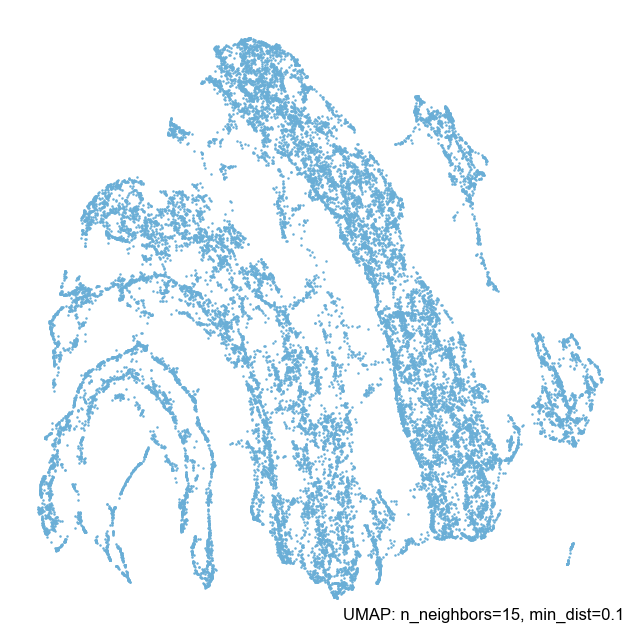

In [118]:
import umap.plot
umap.plot.points(mapper)